In [1]:
from optimade.client import OptimadeClient
import numpy as np
import pandas as pd
import mendeleev as md
from collections import Counter

In [2]:
dfQry = pd.read_pickle('elem5.pkl')
bestQry = dfQry.iloc[dfQry['Fitness Value'].argmin(), :]
# bestQry = dfQry.iloc[3717, :]

In [5]:
# client = OptimadeClient(base_urls=bestQry['Provider List'][0:3])
client = OptimadeClient()
filterQry = bestQry['Filter Query']

In [7]:
client.count(filter=filterQry)

Output()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Counting results for structures/?filter=elements HAS ANY "W","Al","Cd","Zn" AND NOT elements HAS ANY "B", "Cl", │
│ "F", "H", "N", "O", "S", "Se" AND nelements>=5                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Detected a running event loop (e.g., Jupyter, pytest). Running in synchronous mode.

Error: Provider 'https://api.mpds.io' returned: 400 - 
https://api.mpds.io/v1/structures?filter=elements%20HAS%20ANY%20%22W%22,%22Al%22,%22Cd%22,%22Zn%22%20AND%20NOT%20el
ements%20HAS%20ANY%20%22B%22,%20%22Cl%22,%20%22F%22,%20%22H%22,%20%22N%22,%20%22O%22,%20%22S%22,%20%22Se%22%20AND%2
0nelements%3E=5&page_limit=1: Optimade API Response: ANY not supported

{'structures': {'elements HAS ANY "W","Al","Cd","Zn" AND NOT elements HAS ANY "B", "Cl", "F", "H", "N", "O", "S", "Se" AND nelements>=5': {'http://aflow.org/API/optimade/': 2,
   'https://www.crystallography.net/cod/optimade': 17,
   'https://aiida.materialscloud.org/mc3d/optimade': 2,
   'https://aiida.materialscloud.org/mc2d/optimade': 0,
   'https://aiida.materialscloud.org/2dtopo/optimade': 0,
   'https://aiida.materialscloud.org/tc-applicability/optimade': 0,
   'https://aiida.materialscloud.org/pyrene-mofs/optimade': 0,
   'https://aiida.materialscloud.org/curated-cofs/optimade': 0,
   'https://aiida.materialscloud.org/stoceriaitf/optimade': 0,
   'https://aiida.materialscloud.org/autowannier/optimade': 0,
   'https://aiida.materialscloud.org/tin-antimony-sulfoiodide/optimade': 0,
   'https://optimade.materialsproject.org': 4,
   'https://api.mpds.io': None,
   'https://nomad-lab.eu/prod/rae/optimade/': 1781,
   'https://optimade.odbx.science': 0,
   'https://optimade-misc.odbx.s

In [410]:
bestQry

Fitness Value                                             0.666366
Count Mean                                             1446.666667
Count Std                                               787.110468
Count List                                       [2199, 1781, 360]
Input            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
Filter Query     elements HAS ANY "W","Al","Cd","Zn" AND NOT el...
Provider List    [http://oqmd.org/optimade/, https://nomad-lab....
Name: 1692, dtype: object

In [413]:
client.max_results_per_provider = 1500
respFields = ["chemical_formula_descriptive", "species_at_sites","lattice_vectors"]
resStruct = client.get(filter=filterQry.strip(), response_fields=respFields)
providerList = list(resStruct['structures'][filterQry].keys())

Output()

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Performing query structures/?filter=elements HAS ANY "W","Al","Cd","Zn" AND NOT elements HAS ANY "B", "Cl",     │
│ "F", "H", "N", "O", "S", "Se" AND nelements>=5                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Detected a running event loop (e.g., Jupyter, pytest). Running in synchronous mode.

Error: Provider 'http://oqmd.org/optimade/' returned: The read operation timed out

KeyboardInterrupt: 

In [390]:
df = pd.DataFrame(columns=respFields)
df.astype({'chemical_formula_descriptive':str, 'species_at_sites':object, 'lattice_vectors':object})

,chemical_formula_descriptive,species_at_sites,lattice_vectors


In [391]:
for provider in resStruct['structures'][filterQry].keys():
    for entry in resStruct['structures'][filterQry][provider]['data']:
        if type(entry['attributes']['species_at_sites'])==list:
            df = df.append({'provider':provider,
                            'id':entry['id'],
                            'chemical_formula_descriptive':entry['attributes']['chemical_formula_descriptive'],
                            'species_at_sites':entry['attributes']['species_at_sites'],
                            'lattice_vectors':np.array(entry['attributes']['lattice_vectors'])}, ignore_index=True)

In [392]:
densToSIFactor = (1.6605402E-27/1E-30)
df['volume ang^3'] = df.apply(lambda row: np.linalg.det(row['lattice_vectors']), axis=1)
df['mass au'] = df.apply(lambda row: sum([eval(f'md.{elem}.atomic_weight') for elem in row['species_at_sites']]), axis=1)
# df['mass au'] = df.apply(lambda row: sum([md.element(elem).atomic_weight for elem in row['species_at_sites']]), axis=1) #Less dodgy code but much slower
df['density au/ang^3'] = df.apply(lambda row: row['volume ang^3']/row['mass au'], axis=1)
df['density kg/m^3'] = df.apply(lambda row: row['density au/ang^3']*densToSIFactor, axis=1)
df['composition'] = df.apply(lambda row: dict(pd.Series(row['species_at_sites']).value_counts(normalize=True)), axis=1)

In [393]:
allElem = set([])
for row in df['composition']:
    allElem.update(list(row.keys()))
allElem = list(allElem)

In [394]:
def compVecVal(elem, compDict):
    if elem in compDict.keys():
        return compDict[elem]
    else:
        return 0.0

In [395]:
df['compVec'] = df.apply(lambda row: [compVecVal(elem, row['composition']) for elem in allElem], axis=1) #can be made fater? Use sparse vector for compVec?

In [396]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

In [397]:
def getRsq(X_train, X_test, y_train, y_test):
    print(len(y_train)+len(y_test))
#     pipe = make_pipeline(StandardScaler(), MLPRegressor(random_state=1, max_iter=5000, hidden_layer_sizes=(10, 2, ), solver='lbfgs'))
    pipe = make_pipeline(RandomForestRegressor())
    pipe.fit(X_train, y_train)
    print(pipe.score(X_test, y_test))
    return pipe

In [398]:
# df = pd.read_pickle('exampleTrain.pkl')
providerList = list(df['provider'].unique())

X = list(df[df['provider']==providerList[0]]['compVec'])
y = list(df[df['provider']==providerList[0]]['density kg/m^3'])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=1)
model1 = getRsq(X_train1, X_test1, y_train1, y_test1)

1600
0.841027819193788


In [399]:
X = list(df[df['provider']==providerList[1]]['compVec'])
y = list(df[df['provider']==providerList[1]]['density kg/m^3'])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=1)
model2 = getRsq(X_train2, X_test2, y_train2, y_test2)

IndexError: list index out of range

In [380]:
X = list(df['compVec'])
y = list(df['density kg/m^3'])

modelF = getRsq(X_train1+X_train2, X_test1+X_test2, y_train1+y_train2, y_test1+y_test2)

3000
0.9475794668791613


(0.0, 1.0)

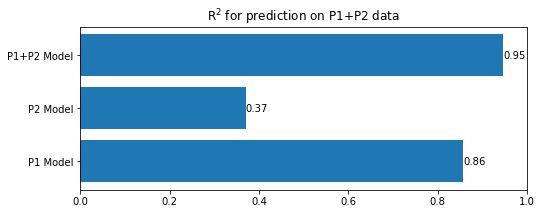

In [381]:
res = [model1.score(X_test1+X_test2, y_test1+y_test2), model2.score(X_test1+X_test2, y_test1+y_test2), modelF.score(X_test1+X_test2, y_test1+y_test2)]
fig, ax = plt.subplots(figsize=(8,3))
p = ax.barh(['P1 Model', 'P2 Model', 'P1+P2 Model'], res)
ax.bar_label(p, fmt='%.2f')
plt.title('R$^2$ for prediction on P1+P2 data')
plt.xlim(0, 1)

(0.0, 3000.0)

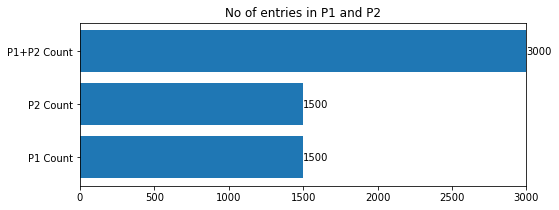

In [387]:
fig, ax = plt.subplots(figsize=(8,3))
p = ax.barh(['P1 Count', 'P2 Count', 'P1+P2 Count'], [sum(df['provider']==providerList[0]), sum(df['provider']==providerList[1]), len(df)])
ax.bar_label(p, fmt='%.2d')
plt.title('No of entries in P1 and P2')
plt.xlim(0, 3000)

In [383]:
df['Unique Elem'] = df.apply(lambda row: set(row['species_at_sites']),axis =1)

In [384]:
list1 = []
list2 = []
for listVal in df['species_at_sites'][df['provider']==providerList[0]]:
    list1 += listVal

for listVal in df['species_at_sites'][df['provider']==providerList[1]]:
    list2 += listVal

dict1 = dict(pd.Series(list1).value_counts(normalize=True))
dict2 = dict(pd.Series(list2).value_counts(normalize=True))

# print('Provider 1: ', dict(pd.Series(list1).value_counts(normalize=True)))
# print('Provider 2: ', dict(pd.Series(list2).value_counts(normalize=True)))

# print('Intersetion: ', set.intersection(set1, set2))

<BarContainer object of 23 artists>

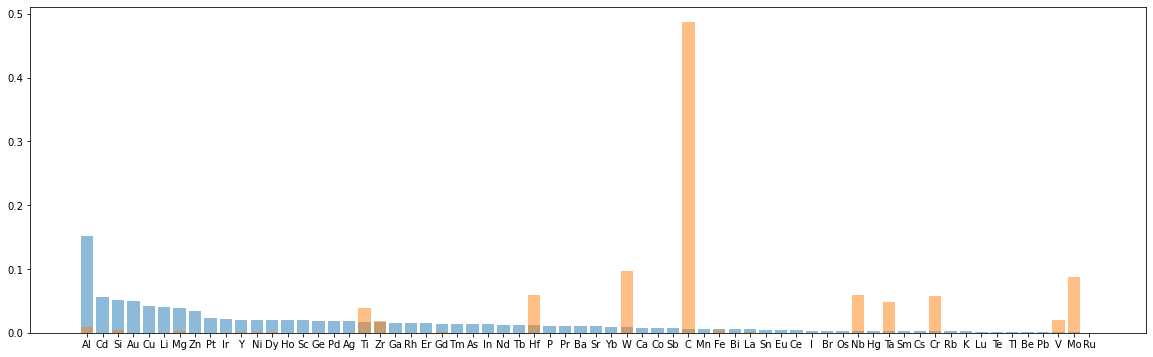

In [385]:


plt.figure(figsize=(20, 6))
plt.bar(dict1.keys(), dict1.values(), alpha =0.5)
plt.bar(dict2.keys(), dict2.values(), alpha =0.5)

In [386]:
set1 = set([])
set2 = set([])
for setVal in df['Unique Elem'][df['provider']==providerList[0]]:
    set1.update(setVal)

for setVal in df['Unique Elem'][df['provider']==providerList[1]]:
    set2.update(setVal)

print('Provider 1: ', set1)
print('Provider 2: ', set2)

print('Intersection: ', set.intersection(set1, set2))

Provider 1:  {'Pr', 'Ge', 'Sc', 'Eu', 'Ir', 'Tm', 'Mg', 'Ag', 'Dy', 'Sn', 'Rh', 'Ce', 'Os', 'Fe', 'Zn', 'La', 'Co', 'Hf', 'V', 'Pb', 'Hg', 'Al', 'Y', 'Cu', 'W', 'Be', 'Yb', 'Pd', 'Ti', 'Tb', 'Ni', 'P', 'Nb', 'Cr', 'Cs', 'K', 'Nd', 'Te', 'I', 'Sm', 'Gd', 'Sr', 'Lu', 'Ca', 'Ba', 'Bi', 'Rb', 'Mo', 'C', 'As', 'Er', 'Zr', 'In', 'Si', 'Au', 'Mn', 'Ho', 'Sb', 'Cd', 'Ga', 'Br', 'Ta', 'Li', 'Pt', 'Tl'}
Provider 2:  {'Mg', 'Dy', 'Sn', 'Sm', 'Gd', 'Fe', 'La', 'Hf', 'V', 'Mo', 'C', 'Al', 'Y', 'Zr', 'Si', 'W', 'Mn', 'Ti', 'Ta', 'Ni', 'Nb', 'Ru', 'Cr'}
Intersection:  {'Mg', 'Dy', 'Sn', 'Fe', 'La', 'Hf', 'V', 'Al', 'Y', 'W', 'Ti', 'Ni', 'Nb', 'Cr', 'Sm', 'Gd', 'Mo', 'C', 'Zr', 'Si', 'Mn', 'Ta'}


In [360]:
df

,chemical_formula_descriptive,species_at_sites,lattice_vectors,id,provider,volume ang^3,mass au,density au/ang^3,density kg/m^3,composition,compVec,Unique Elem
0,Al12Dy5Fe4Mg5Si6,"[Dy, Dy, Dy, Dy, Dy, Mg, Mg, Mg, Mg, Mg, Al, A...","[[11.883426, 0.0, 0.0], [0.0, 11.883426, 0.0],...",VrKV8WumcCHbcFyripzhjkiJU6tQ,https://nomad-lab.eu/prod/rae/optimade/,563.885334,1649.693462,0.341812,567.592882,"{'Al': 0.375, 'Si': 0.1875, 'Dy': 0.15625, 'Mg...","[0.0, 0.15625, 0.15625, 0.0, 0.125, 0.0, 0.0, ...","{Al, Si, Mg, Dy, Fe}"
1,Al12Dy5Fe4Mg5Si6,"[Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, A...","[[1.844665, 0.0, 0.0], [0.0, 1.844665, 0.0], [...",fT5hwkZDruASrHjG60v5v1wZlrxh,https://nomad-lab.eu/prod/rae/optimade/,13.571690,1649.693462,0.008227,13.660924,"{'Al': 0.375, 'Si': 0.1875, 'Dy': 0.15625, 'Mg...","[0.0, 0.15625, 0.15625, 0.0, 0.125, 0.0, 0.0, ...","{Al, Si, Mg, Dy, Fe}"
2,Al12Dy5Fe4Mg5Si6,"[Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, A...","[[11.841774, 0.0, 0.0], [0.0, 11.841774, 0.0],...",qB0jGKVRYulPiKgi_iJFW670XEfO,https://nomad-lab.eu/prod/rae/optimade/,559.265997,1649.693462,0.339012,562.943172,"{'Al': 0.375, 'Si': 0.1875, 'Dy': 0.15625, 'Mg...","[0.0, 0.15625, 0.15625, 0.0, 0.125, 0.0, 0.0, ...","{Al, Si, Mg, Dy, Fe}"
3,Al12Dy5Fe4Mg5Si6,"[Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, A...","[[11.84177414, 0.0, 0.0], [0.0, 11.84177414, 0...",jlgdpsbpH8OeFiyp94nT6zC0LUtM,https://nomad-lab.eu/prod/rae/optimade/,559.266006,1649.693462,0.339012,562.943181,"{'Al': 0.375, 'Si': 0.1875, 'Dy': 0.15625, 'Mg...","[0.0, 0.15625, 0.15625, 0.0, 0.125, 0.0, 0.0, ...","{Al, Si, Mg, Dy, Fe}"
4,Al12Fe4Gd5Mg5Si6,"[Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, A...","[[11.89549619, 0.0, 0.0], [0.0, 11.89549619, 0...",o8LrC_EALrDiVSXFhtBq70gFUPc7,https://nomad-lab.eu/prod/rae/optimade/,566.724579,1623.443462,0.349088,579.674604,"{'Al': 0.375, 'Si': 0.1875, 'Gd': 0.15625, 'Mg...","[0.0, 0.15625, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0,...","{Al, Si, Mg, Gd, Fe}"
...,...,...,...,...,...,...,...,...,...,...,...,...
1855,K2 Y2 Zn4 I2 Br14,"[K, K, I, I, Y, Y, Zn, Zn, Zn, Zn, Br, Br, Br,...","[[-0.0171682910968, -7.87453414456, -0.0705352...",law-gnn-K1Y1Zn2Br7I1_icsd_166998_2,https://optimade-misc.odbx.science,850.641580,1889.993220,0.450077,747.370163,"{'Br': 0.5833333333333334, 'Zn': 0.16666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1666666666666...","{Y, K, I, Br, Zn}"
1856,K2 Y2 Cd4 I2 Br14,"[K, K, I, I, Y, Y, Cd, Cd, Cd, Cd, Br, Br, Br,...","[[-0.253789544571, -7.69819487129, -0.58522257...",law-gnn-K1Y1Cd2Br7I1_icsd_166998_2,https://optimade-misc.odbx.science,867.488649,2078.129220,0.417437,693.171416,"{'Br': 0.5833333333333334, 'Cd': 0.16666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","{Y, K, I, Br, Cd}"
1857,Dy5 Mg5 Al12 Fe4 Si6,"[Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, A...","[[11.841774, 0.0, 0.0], [0.0, 11.841774, 0.0],...",camd-oqmd_24094,https://optimade-misc.odbx.science,559.265997,1649.693462,0.339012,562.943172,"{'Al': 0.375, 'Si': 0.1875, 'Dy': 0.15625, 'Mg...","[0.0, 0.15625, 0.15625, 0.0, 0.125, 0.0, 0.0, ...","{Al, Si, Mg, Dy, Fe}"
1858,Gd5 Mg5 Al12 Fe4 Si6,"[Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, A...","[[11.895496, 0.0, 0.0], [0.0, 11.895496, 0.0],...",camd-oqmd_24095,https://optimade-misc.odbx.science,566.724616,1623.443462,0.349088,579.674642,"{'Al': 0.375, 'Si': 0.1875, 'Gd': 0.15625, 'Mg...","[0.0, 0.15625, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0,...","{Al, Si, Mg, Gd, Fe}"


Text(0, 0.5, 'Fitness')

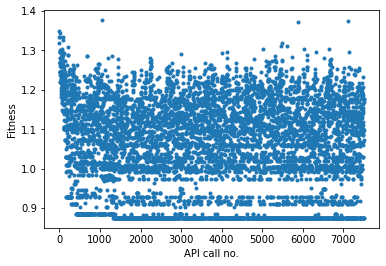

In [361]:
data4 = pd.read_pickle('elem.pkl')
plt.plot(data4['Fitness Value'], '.')
plt.xlabel('API call no.')
plt.ylabel('Fitness')

Text(0, 0.5, 'Fitness')

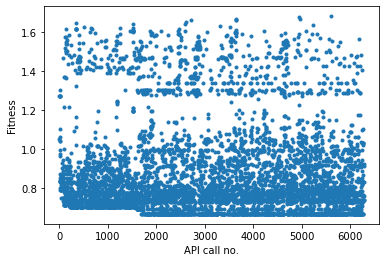

In [363]:
data5 = pd.read_pickle('elem5.pkl')
plt.plot(data5['Fitness Value'], '.')
plt.xlabel('API call no.')
plt.ylabel('Fitness')

In [404]:
client = OptimadeClient()

In [405]:
client.base_urls

['http://aflow.org/API/optimade/',
 'https://www.crystallography.net/cod/optimade',
 'https://aiida.materialscloud.org/mc3d/optimade',
 'https://aiida.materialscloud.org/mc2d/optimade',
 'https://aiida.materialscloud.org/2dtopo/optimade',
 'https://aiida.materialscloud.org/tc-applicability/optimade',
 'https://aiida.materialscloud.org/pyrene-mofs/optimade',
 'https://aiida.materialscloud.org/curated-cofs/optimade',
 'https://aiida.materialscloud.org/stoceriaitf/optimade',
 'https://aiida.materialscloud.org/autowannier/optimade',
 'https://aiida.materialscloud.org/tin-antimony-sulfoiodide/optimade',
 'https://optimade.materialsproject.org',
 'https://api.mpds.io',
 'https://nomad-lab.eu/prod/rae/optimade/',
 'https://optimade.odbx.science',
 'https://optimade-misc.odbx.science',
 'http://optimade.openmaterialsdb.se',
 'http://oqmd.org/optimade/',
 'https://www.crystallography.net/tcod/optimade',
 'http://optimade.2dmatpedia.org']